In [4]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score
import itertools
from common import *

In [5]:
chromosome = 10

# Arrowhead

In [150]:
cols = ["chr1", "x1", "x2", "chr2", "y1", "y2"]
df = pd.read_csv("data/GSE63525_GM12878_primary+replicate_Arrowhead_domainlist.txt", sep="\t", usecols=cols)
df = df[df.chr1 == df.chr2]
df = df[df.chr1 == str(chromosome)]

df["start"] = df.x1.apply(lambda x: x/1000_00)
df["end"] = df.x2.apply(lambda x: x/1000_00)
df["size"] = df.end - df.start

#df["original_size"] = df.x2 / 1000_000 - df.x1 / 1000_000

df.sort_values(by="size", ascending=False, inplace=True)
df

,chr1,x1,x2,chr2,y1,y2,start,end,size
889,10,127640000,129495000,10,127640000,129495000,1276.40,1294.95,18.55
890,10,86420000,88145000,10,86420000,88145000,864.20,881.45,17.25
891,10,9365000,11065000,10,9365000,11065000,93.65,110.65,17.00
893,10,132020000,133380000,10,132020000,133380000,1320.20,1333.80,13.60
892,10,52710000,53995000,10,52710000,53995000,527.10,539.95,12.85
...,...,...,...,...,...,...,...,...,...
1332,10,25170000,25245000,10,25170000,25245000,251.70,252.45,0.75
1191,10,60090000,60160000,10,60090000,60160000,600.90,601.60,0.70
1269,10,98520000,98590000,10,98520000,98590000,985.20,985.90,0.70
1270,10,71005000,71070000,10,71005000,71070000,710.05,710.70,0.65


In [151]:
(df.x2.max() - df.x1.min()) / 1000_00

1344.7

In [152]:
df["size"].sum()

1103.249999999998

In [153]:
# only to check size
df["size"] = df[df["size"] >= 5]["size"]
df.dropna(inplace=True)

In [155]:
df["size"].sum() / 1103

0.2843155031731634

In [148]:
effective_size(df["size"]), df["size"].median()

(8.322167484124575, 6.399999999999864)

[]

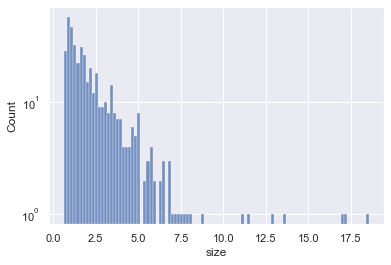

In [127]:
sns.histplot(df, x="size", bins=100)
plt.semilogy()

In [142]:
#df["size"] = df["size"].round()
df["range"] = df.apply(lambda x: range(int(x.start), int(x.end) + 1), axis=1)

tads = df.range.apply(list).reset_index(drop=True)
tads

0      [1276, 1277, 1278, 1279, 1280, 1281, 1282, 128...
1      [864, 865, 866, 867, 868, 869, 870, 871, 872, ...
2      [93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 10...
3      [1320, 1321, 1322, 1323, 1324, 1325, 1326, 132...
4      [527, 528, 529, 530, 531, 532, 533, 534, 535, ...
                             ...                        
439                                           [251, 252]
440                                           [600, 601]
441                                                [985]
442                                                [710]
443                                           [649, 650]
Name: range, Length: 444, dtype: object

In [137]:
nodes = [node for tad in tads for node in tad]

len(nodes), len(nodes) - len(set(nodes))

(1106, 314)

In [138]:
node_to_module = {}
for module, nodes in tads.to_dict().items():
    if any(node in node_to_module for node in nodes):
        continue
    for node in nodes:
        node_to_module[node] = module

flow = 1 / float(len(node_to_module))

with open("output/arrowhead.clu", "w") as f:
    f.write("# arrowhead tads\n")
    f.write("# node module flow\n")
    for node, module in node_to_module.items():
        f.write(f"{node} {module + 1} {flow:.5f}\n")

In [139]:
max_module = max(node_to_module.values())
max_node = 1355

partition = np.arange(0, max_node, dtype=np.int32) + max_module + 1

for node, module in node_to_module.items():
    partition[node] = module

alpha = 75
gammas = np.arange(50, 205, 5, dtype=np.int32)
ami = []

for gamma in gammas:
    partitions = pd.read_csv(f"matlab/output/A1_chr{chromosome}_gamma{gamma}_alpha{alpha}_partitions.csv", sep=" ", header=None)
    ami_ = adjusted_mutual_info_score(partition, partitions[0])
    ami.append(ami_)

In [140]:
max(ami)

0.5266031497608227

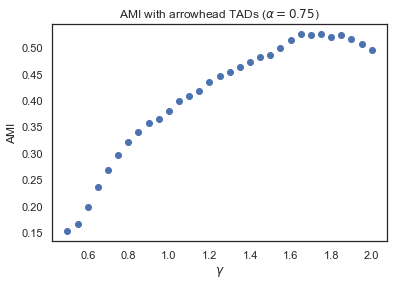

In [141]:
sns.set_style("white")
plt.scatter([gamma/100 for gamma in gammas], ami)
plt.ylabel("AMI")
plt.xlabel("$\gamma$")
plt.title("AMI with arrowhead TADs ($\\alpha=0.75$)")
plt.savefig(f"results/tads_ami_alpha{alpha}.png", dpi=600, bbox_inches="tight")

# A/B compartments

In [17]:
comp = pd.read_csv("data/GSE63525_GM12878_subcompartments.bed", sep="\t", names=["chr", "x1", "x2", "comp", "UNKNOWN1", "UNKNOWN2", "y1", "y2", "color"], index_col=False)

comp = comp[comp.chr == f"chr{chromosome}"].reset_index(drop=True)

comp = comp.drop(columns=["chr", "UNKNOWN1", "UNKNOWN2", "y1", "y2", "color"])
comp = comp.dropna(subset="comp")

comp["super"] = comp.comp.apply(lambda c: c[0])

comp["start"] = comp.x1.apply(lambda x: x // 100_000) # 100 kb
comp["end"] =   comp.x2.apply(lambda x: x // 100_000)

comp["range"] = comp.apply(lambda x: range(x.start, x.end), axis=1)

comp["size"] = comp.end - comp.start
comp["original_size"] = comp.x2 - comp.x1

comp.sort_values(by=["super", "start"], inplace=True)
comp

,x1,x2,comp,super,start,end,range,size,original_size
2,900000,1100000,A1,A,9,11,"(9, 10)",2,200000
6,3100000,3200000,A2,A,31,32,(31),1,100000
12,3800000,4100000,A2,A,38,41,"(38, 39, 40)",3,300000
16,5600000,5800000,A2,A,56,58,"(56, 57)",2,200000
17,5800000,6000000,A1,A,58,60,"(58, 59)",2,200000
...,...,...,...,...,...,...,...,...,...
212,128700000,129800000,B2,B,1287,1298,"(1287, 1288, 1289, 1290, 1291, 1292, 1293, 129...",11,1100000
214,130000000,131900000,B2,B,1300,1319,"(1300, 1301, 1302, 1303, 1304, 1305, 1306, 130...",19,1900000
216,132000000,133700000,B2,B,1320,1337,"(1320, 1321, 1322, 1323, 1324, 1325, 1326, 132...",17,1700000
217,133700000,135100000,B1,B,1337,1351,"(1337, 1338, 1339, 1340, 1341, 1342, 1343, 134...",14,1400000


[]

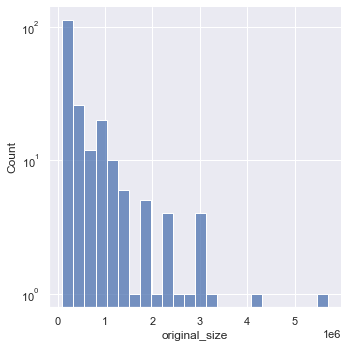

In [18]:
sns.displot(comp, x="original_size")
plt.semilogy()

In [12]:
#C = comp.groupby("comp")["range"].agg(lambda x: list(itertools.chain(*x)))
C = comp.groupby("comp")["range"].agg(lambda x: list(x))
C

comp
A1    [(9, 10), (58, 59), (120, 121, 122, 123, 124),...
A2    [(31), (38, 39, 40), (56, 57), (60, 61, 62, 63...
B1    [(1, 2, 3, 4, 5, 6, 7, 8), (11, 12, 13, 14, 15...
B2    [(18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, ...
B3    [(525), (527), (529), (531, 532, 533, 534, 535...
Name: range, dtype: object

In [13]:
#effective_size(comp.groupby("comp")["range"].agg(lambda r: len(list(itertools.chain(*r))))) * 100
effective_size(comp["original_size"]) / 1000
#comp["range"].agg(lambda x: len(x) * 100).describe()

1101.7923141198453

In [14]:
comp.groupby("comp")["original_size"].sum() / 1000

comp
A1    11500.0
A2    34300.0
B1    17700.0
B2    32900.0
B3    31100.0
Name: original_size, dtype: float64

# Write clu file

In [15]:
with open(f"output/A12B123.clu", "w") as f:
    f.write("# aoeu\n")
    
    flow = 1 / comp.end.max()
    
    for label, c in enumerate(C):
        for pos in c:
            f.write(f"{pos - 1} {label} {flow}\n")

In [76]:
with open(f"output/A12B123.tree", "w") as f:
    f.write("# A/B-compartments\n")
    
    flow = 1 / comp.end.max()
    
    i = 1
    
    for compartment, c in C.iteritems():
        for sub, range_ in enumerate(c):
            for pos in range_:
                # path flow name id
                path = f"{1 if compartment.startswith('B') else 2}:{compartment[-1]}:{sub+1}:{i}"
                i += 1
                id_ = pos - 1
                f.write(f"{path} {flow} \"{id_}\" {id_}\n")

## AMI with best partition

In [7]:
from collections import defaultdict

size = comp.end.max()

partition = np.arange(0, size, dtype=np.int32) + 1000

label_id = defaultdict(lambda: len(label_id) + 1)

for label, (compartment, c) in enumerate(C.iteritems()):
    for sub, range_ in enumerate(c):
        for pos in range_:
            #partition[pos - 1] = 1 if compartment == 'B' else 0
            partition[pos - 1] = label_id[f"{label}:{sub}"]

partition

array([  93,   93,   93, ...,  145,  145, 2354], dtype=int32)

In [8]:
gammas = [50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130]
ami = []
ari = []
alpha = 75

for gamma in gammas:
    partitions = pd.read_csv(f"matlab/output/A1_chr{chromosome}_gamma{gamma}_alpha{alpha}_partitions.csv", sep=" ", header=None)
    ami_ = adjusted_mutual_info_score(partition, partitions[0])
    ari_ = adjusted_rand_score(partition, partitions[0])
    ami.append(ami_)
    ari.append(ari_)
    print(f"{gamma=}", ami_)

gamma=50 0.3416414112668198
gamma=55 0.37660654632104446
gamma=60 0.4339998885189197
gamma=65 0.5094981244123907
gamma=70 0.552320484979882
gamma=75 0.6030960313072515
gamma=80 0.6266490099834007
gamma=85 0.6549387769812152
gamma=90 0.6713756718370867
gamma=95 0.6729049984159914
gamma=100 0.6816013675944532
gamma=105 0.6982451747164993
gamma=110 0.7141142245671251
gamma=115 0.719506104995707
gamma=120 0.7187560605710698
gamma=125 0.7041496317265913
gamma=130 0.6914713138679486


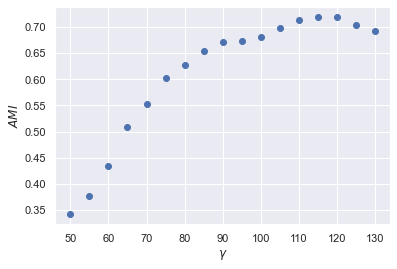

In [9]:
plt.scatter(gammas, ami)
#plt.scatter(gammas, ari)
plt.xlabel("$\gamma$")
plt.ylabel("$AMI$")
plt.savefig("results/ami.png", dpi=600)

In [74]:
nodes = pd.read_csv("matlab/output/A1_chr10_gamma50_alpha108.csv", sep=" ", header=None)[0]
flow = 1/len(nodes)
nodes_per_module = 10
n_modules = int(len(nodes) / nodes_per_module)
print(n_modules)
with open(f"output/nodes_{nodes_per_module}.tree", "w") as f:
    f.write("# nodes\n")
    f.write("#path flow name node_id\n")
    i = 0
    for module in range(n_modules):
        for node_num in range(nodes_per_module):
            f.write(f"{module + 1}:{nodes[i] + 1} {flow} \"{nodes[i]}\" {nodes[i]}\n")
            i += 1

135


In [70]:
effective_size(pd.read_csv("matlab/output/A1_chr10_gamma130_alpha75_partitions.csv", sep=" ", header=None)[0])

89.25018374673634

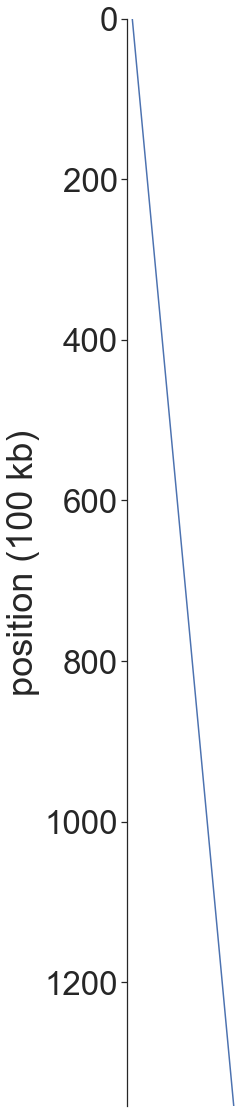

In [53]:
sns.set(rc={"figure.figsize": (2, 20)})
sns.set(font_scale=3)
sns.set_style("ticks")
ax = sns.lineplot(nodes)
ax.invert_yaxis()
sns.despine(bottom=True)
plt.ylabel("position (100 kb)")
plt.ylim([max(nodes), 0])
plt.xticks([])
plt.savefig("results/pos_y_axis.pdf", bbox_inches="tight")

## Jaccard index with core communities

In [448]:
gamma = 50
df = pd.read_csv(f"output/A1_chr{chromosome}_gamma{gamma}_significant_0.csv").sort_values("node").reset_index(drop=True)
df.node = df.node + 1
df

,module,node
0,1,1
1,1,2
2,1,3
3,1,4
4,1,5
...,...,...
1330,1,1351
1331,1,1352
1332,1,1353
1333,1,1354


In [449]:
def jaccard_index(p, q):
    p = set(p)
    q = set(q)
    return len(p.intersection(q)) / len(p.union(q))

In [450]:
df[df.module == 1].node

0          1
1          2
2          3
3          4
4          5
        ... 
1330    1351
1331    1352
1332    1353
1333    1354
1334    1355
Name: node, Length: 1289, dtype: int64

In [451]:
ji = []

label = "B"

for gamma in gammas:
    try:
        df = pd.read_csv(f"output/A1_chr{chromosome}_gamma{gamma}_significant_0.csv").sort_values("node").reset_index(drop=True)
    except FileNotFoundError:
        break
    df.node = df.node + 1
    ji.append(jaccard_index(C[label], df[df.module == 2].node))

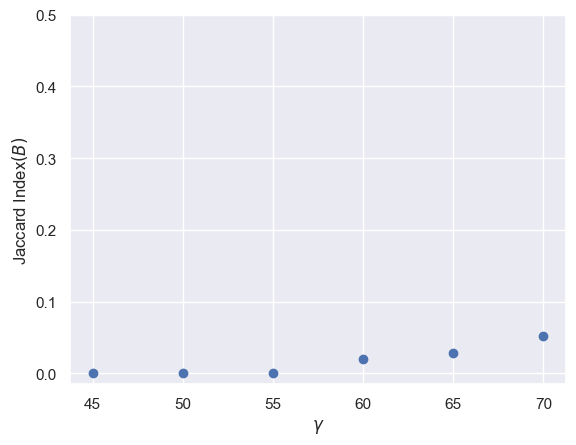

In [452]:
plt.scatter(gammas[0:6], ji)
plt.xlabel("$\gamma$")
plt.ylabel(f"Jaccard Index$({label})$")
plt.ylim(-0.015, top=0.5)
plt.savefig(f"results/ji_{label}.png", dpi=600)